# Type: Pullover & Dress

## a. Loading dan Scalling data

In [ ]:
# Import TensorFlow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


In [ ]:
import numpy as np
import os

def load_mnist_unzipped(path, kind='train'):
    """Load MNIST data from `path` without gzip compression"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    
    with open(labels_path, 'rb') as lbpath:
        # The first 8 bytes are magic number and number of labels
        lbpath.read(8)
        # Read the rest as uint8
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        # The first 16 bytes are magic number, number of images, rows, and columns
        imgpath.read(16)
        # Read the rest as uint8 and reshape according to number of images and size of 28*28
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 28, 28)
    
    return images, labels

In [ ]:
x_train, y_train = load_mnist_unzipped('fashion/', kind='train')
x_test, y_test = load_mnist_unzipped('fashion/', kind='t10k')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
# Scalling dan memilih hanya menggunakan 'Pullover' dan 'Dress' dari dataset
from tensorflow.keras.datasets import fashion_mnist

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Select images with labels 2 and 3 for training set
train_mask = (y_train == 2) | (y_train == 3)
x_train_filtered = x_train[train_mask]
y_train_filtered = y_train[train_mask]

# Select images with labels 2 and 3 for test set
test_mask = (y_test == 2) | (y_test == 3)
x_test_filtered = x_test[test_mask]
y_test_filtered = y_test[test_mask]

# Print shapes to verify
print("Filtered training data shape:", x_train_filtered.shape)
print("Filtered test data shape:", x_test_filtered.shape)

# Print first 10 filtered labels from the training set
print("First 10 filtered labels from the training set:", y_train_filtered[:10])
# Print first 10 filtered labels from the test set
print("First 10 filtered labels from the test set:", y_test_filtered[:10])


Filtered training data shape: (12000, 28, 28)
Filtered test data shape: (2000, 28, 28)
First 10 filtered labels from the training set: [3 2 2 3 3 2 3 2 2 3]
First 10 filtered labels from the test set: [2 3 2 2 3 3 3 3 2 2]


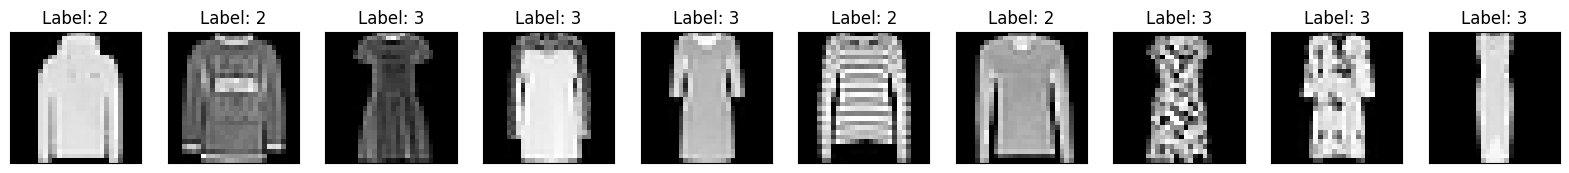

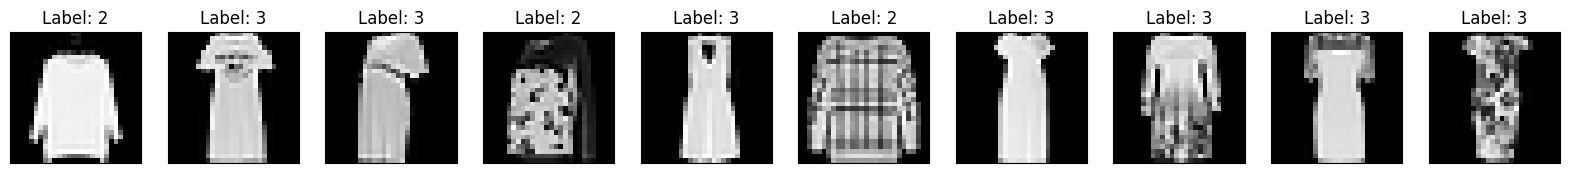

In [ ]:
# Display 10 example images from the filtered training data
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train_filtered[i], cmap='gray')
    plt.title(f"Label: {y_train_filtered[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Display 10 example images from the filtered test data
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_filtered[i], cmap='gray')
    plt.title(f"Label: {y_test_filtered[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Splitting 80% training set, 10% validation set dan 10% test set

In [ ]:
from sklearn.model_selection import train_test_split

# Define the ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split the training data into train and validation sets
x_train_filtered, x_val, y_train_filtered, y_val = train_test_split(
    x_train_filtered, y_train_filtered, test_size=val_ratio, random_state=42)

# Split the test data into test and validation sets
x_test_filtered, x_val, y_test_filtered, y_val = train_test_split(
    x_test_filtered, y_test_filtered, test_size=val_ratio, random_state=42)

# Print shapes to verify
print("Training set shapes:")
print("x_train_filtered shape:", x_train_filtered.shape)
print("y_train_filtered shape:", y_train_filtered.shape)
print("Validation set shapes:")
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("Test set shapes:")
print("x_test_filtered shape:", x_test_filtered.shape)
print("y_test_filtered shape:", y_test_filtered.shape)


Training set shapes:
x_train_filtered shape: (10800, 28, 28)
y_train_filtered shape: (10800,)
Validation set shapes:
x_val shape: (200, 28, 28)
y_val shape: (200,)
Test set shapes:
x_test_filtered shape: (1800, 28, 28)
y_test_filtered shape: (1800,)


Adding random noise to the images

In [ ]:
noise_factor = 0.2
x_train_noisy = x_train_filtered + noise_factor * tf.random.normal(shape=x_train_filtered.shape)
x_test_noisy = x_test_filtered + noise_factor * tf.random.normal(shape=x_test_filtered.shape)
x_val_noisy = x_val + noise_factor * tf.random.normal(shape=x_val.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
x_val_noisy = tf.clip_by_value(x_val_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


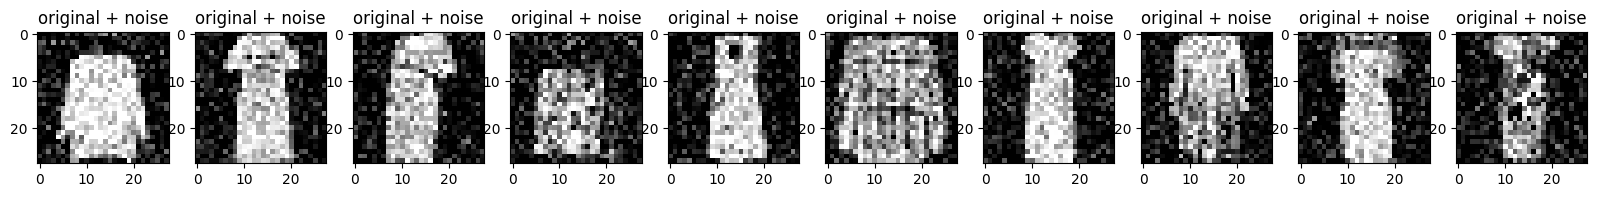

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## b. Modelling Autoencoder untuk Dimension Reduction

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(128, activation='relu')
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(6272, activation='relu'),  # Fully connected layer
            layers.Reshape((14, 14, 32)),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train_filtered,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_filtered))

Epoch 1/10


338/338 [==============================] - 21s 61ms/step - loss: 0.0291 - val_loss: 0.0161
Epoch 2/10
338/338 [==============================] - 23s 68ms/step - loss: 0.0131 - val_loss: 0.0117
Epoch 3/10
338/338 [==============================] - 18s 53ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 4/10
338/338 [==============================] - 17s 52ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 5/10
338/338 [==============================] - 18s 54ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 6/10
338/338 [==============================] - 22s 66ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 7/10
338/338 [==============================] - 19s 57ms/step - loss: 0.0076 - val_loss: 0.0085
Epoch 8/10
338/338 [==============================] - 19s 57ms/step - loss: 0.0073 - val_loss: 0.0081
Epoch 9/10
338/338 [==============================] - 25s 75ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 10/10
338/338 [==============================] - 20s 58ms/step - loss: 0.0067 - val_los

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 784 to 128

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               802944    
                                                                 
Total params: 803,264
Trainable params: 803,264
Non-trainable params: 0
_________________________________________________________________


The decoder upsamples the images back

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 reshape_3 (Reshape)         (None, 14, 14, 32)        0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 1)         289       
                                                                 
Total params: 818,625
Trainable params: 818,625
Non-trainable params: 0
________________________________________________

### Evaluasi kualitas citra hasil decoder menggunakan Structural Similarity Index (SSIM)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

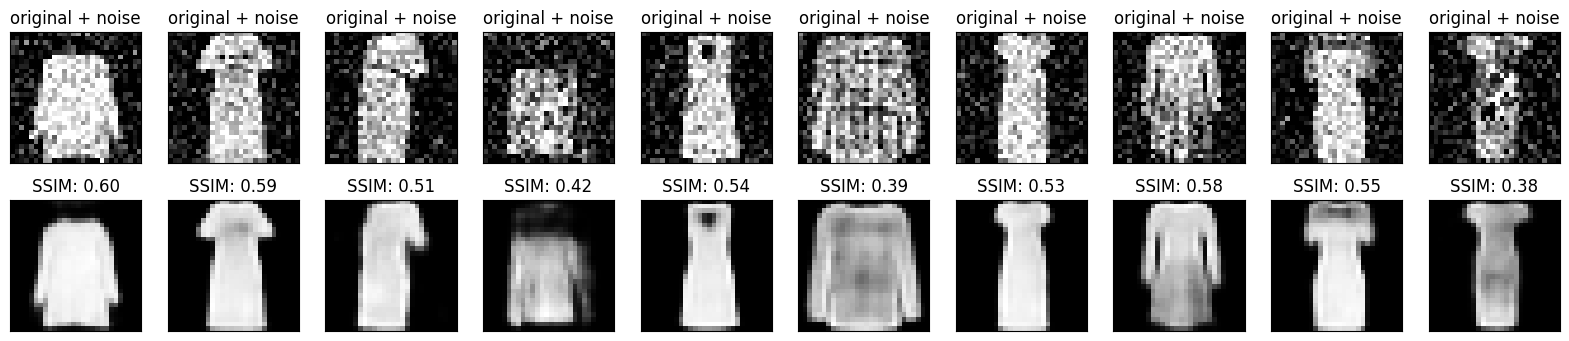

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# Compute SSIM for each pair of original and reconstructed images
ssim_values = []
for i in range(len(x_test_noisy)):
    original = tf.squeeze(x_test_noisy[i]).numpy()
    reconstructed = tf.squeeze(decoded_imgs[i]).numpy()
    ssim_score, _ = ssim(original, reconstructed, data_range=original.max() - original.min(), full=True)
    ssim_values.append(ssim_score)

# Display images with SSIM scores
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed + SSIM score
    bx = plt.subplot(2, n, i + n + 1)
    plt.title(f"SSIM: {ssim_values[i]:.2f}")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()


## c. Modifikasi arsitektur dan tuning hyperparameter

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class Denoise2(Model):
    def __init__(self):
        super(Denoise2, self).__init__()
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Dropout(0.25),  # Dropout layer added
            layers.BatchNormalization(),  # Batch normalization layer
            layers.Flatten(),
            layers.Dense(128, activation='relu')
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(6272, activation='relu'),  # Fully connected layer
            layers.Reshape((14, 14, 32)),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create an instance of the model
autoencoder2 = Denoise2()

Modifikasi Arsitektur dilakukan dengan penambahan lapisan dropout (0.25) dan batch normalization dalam encoder untuk meningkatkan generalisasi dan stabilitas pelatihan.

In [ ]:
# Define hyperparameters to tune
learning_rate = 0.001
batch_size = 64
epochs = 20

# Compile the model
autoencoder2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

history = autoencoder2.fit(x_train_filtered, x_train_filtered, epochs=10, batch_size=32, validation_data=(x_val, x_val))

Epoch 1/10
338/338 [==============================] - 22s 64ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 2/10
338/338 [==============================] - 20s 60ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 3/10
338/338 [==============================] - 21s 62ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 4/10
338/338 [==============================] - 21s 61ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 5/10
338/338 [==============================] - 20s 59ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 6/10
338/338 [==============================] - 19s 56ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 7/10
338/338 [==============================] - 20s 59ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/10
338/338 [==============================] - 20s 60ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 9/10
338/338 [==============================] - 21s 63ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 10/10
338/338 [==============================] - 19s 56ms/step - loss: 0.004

Dilakukan Tuning Hyperparameter dengan menatur nilai Learning rate pada 0.001 untuk memastikan konvergensi yang stabil. Batch size diatur pada 64 untuk keseimbangan antara kecepatan pelatihan dan stabilitas gradient. Jumlah epochs diatur pada 20 (dilatih terlebih dahulu selama 10 epochs) untuk memberikan cukup waktu bagi model untuk belajar tanpa overfitting.

### Evaluasi kualitas citra hasil decoder menggunakan Structural Similarity Index (SSIM)

In [ ]:
encoded_imgs2 = autoencoder2.encoder(x_test_noisy).numpy()
decoded_imgs2 = autoencoder2.decoder(encoded_imgs2).numpy()

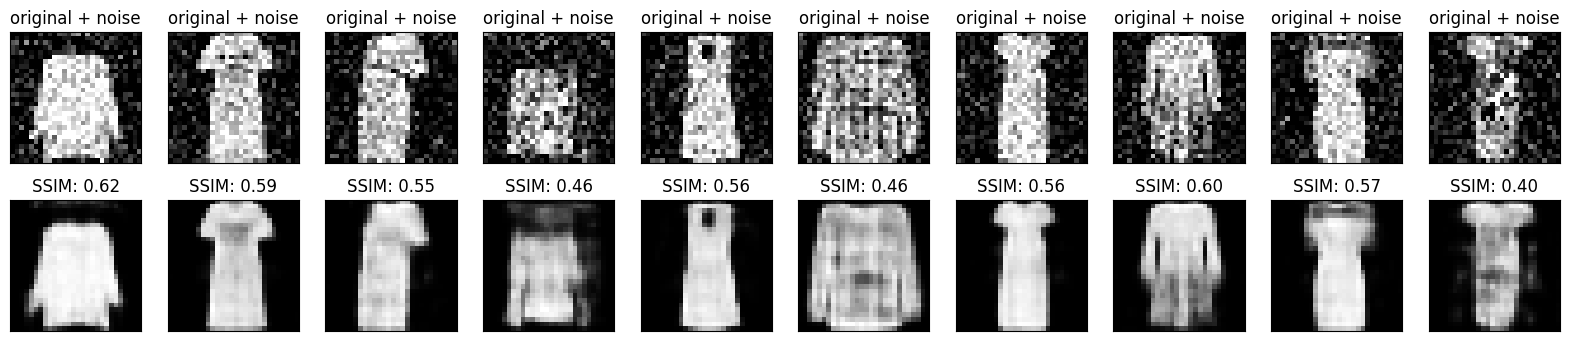

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# Compute SSIM for each pair of original and reconstructed images
ssim_values = []
for i in range(len(x_test_noisy)):
    original = tf.squeeze(x_test_noisy[i]).numpy()
    reconstructed = tf.squeeze(decoded_imgs2[i]).numpy()
    ssim_score, _ = ssim(original, reconstructed, data_range=original.max() - original.min(), full=True)
    ssim_values.append(ssim_score)

# Display images with SSIM scores
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed + SSIM score
    bx = plt.subplot(2, n, i + n + 1)
    plt.title(f"SSIM: {ssim_values[i]:.2f}")
    plt.imshow(tf.squeeze(decoded_imgs2[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()


### Kesimpulan

Model 1: ![image.png](attachment:image.png)
Model 2 (modifikasi dan tuning hyperparameter): ![![image-2.png](https://)](attachment:image-2.png)

Skor Structural Similarity Index (SSIM) Model 2 lebih tinggi daripada Model 1.

# Generative Adversarial Network (GAN)

## a. Cara Kerja Arsitektur

![![image.png](https://)](attachment:image.png)

Pertama - tama Generator mengambil input berupa random noise acak yang diproses melalui beberapa layer neural network dan menghasilkan output berupa fake image atau gambar palsu yang mirip dengan gambar asli dataset, setelah itu gambar palsu tadi menjadi input dari discriminator beserta training set berupa beberapa data gambar asli dari dataset. Terakhir, discriminator akan memproses input melalui beberapa layer neural network dan menghasilkan output berupa keputusan bahwa apakah gambar yang diinput itu real (asli) atau fake (palsu). Proses dari arsitektur diulang sampai discriminator dapat membedakan gambar real dan fake dengan baik.

## b. Image Generation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.10.0


### Load the dataset

In [ ]:
import numpy as np
import os

def load_mnist_unzipped(path, kind='train'):
    """Load MNIST data from `path` without gzip compression"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')
    
    with open(labels_path, 'rb') as lbpath:
        # The first 8 bytes are magic number and number of labels
        lbpath.read(8)
        # Read the rest as uint8
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)
    
    with open(images_path, 'rb') as imgpath:
        # The first 16 bytes are magic number, number of images, rows, and columns
        imgpath.read(16)
        # Read the rest as uint8 and reshape according to number of images and size of 28*28
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 28, 28)
    
    return images, labels

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


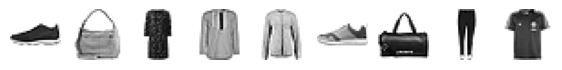

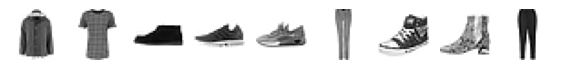

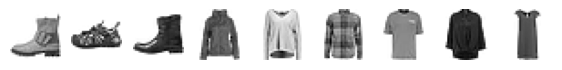

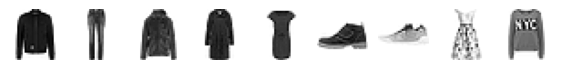

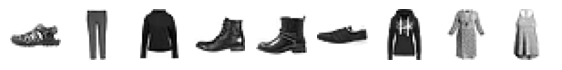

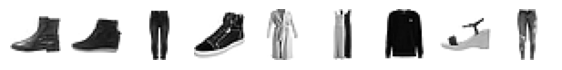

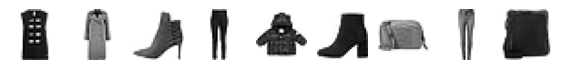

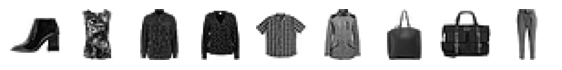

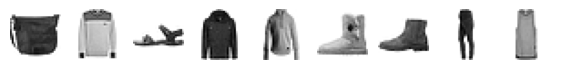

In [ ]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = load_mnist_unzipped('fashion/', kind='train'), load_mnist_unzipped('fashion/', kind='t10k')

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

### Data Normalization

In [ ]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


In [ ]:
# Filter the dataset to include only labels 2 and 3
label_2_and_3_indices = np.where((trainY == 2) | (trainY == 3))[0]
train_images = trainX[label_2_and_3_indices]
train_labels = trainY[label_2_and_3_indices]

### Modelling

#### Generator Network

In [ ]:
batch_size = 100

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def make_generator_model():
    noise_dim = 100
    num_labels = 2  # Since we're only using labels 2 and 3
    
    random_input = tf.keras.layers.Input(shape=(noise_dim + num_labels))
    
    x = tf.keras.layers.Dense(128, use_bias=False)(random_input)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dense(256, use_bias=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dense(512, use_bias=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Dense(1024, use_bias=False)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Dense(28*28, activation='tanh')(x)
    generated_image = tf.keras.layers.Reshape((28, 28, 1))(x)
    
    generator_network = tf.keras.models.Model(inputs=random_input, outputs=generated_image)
    
    return generator_network

# Create the generator network
generator_network = make_generator_model()
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102)]             0         
                                                                 
 dense (Dense)               (None, 128)               13056     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               32768     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131072    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0     

#### Discriminator Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_discriminator_model():
    num_labels = 2  # Since we're only using labels 2 and 3
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(1,input_shape=(28, 28, 1)))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(1))
    
    return model

# Create the discriminator network
discriminator_network = make_discriminator_model()
discriminator_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 28, 28, 1)         2         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               401408    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              524288    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              1

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

#### GAN, Defining combined model

In [ ]:
noise_dim = 100
num_labels = 2  # Since we're only using labels 2 and 3
    
random_input = tf.keras.layers.Input(shape=(noise_dim + num_labels))

discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 102)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         1504784   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2499075   
                                                                 
Total params: 4,003,859
Trainable params: 1,504,784
Non-trainable params: 2,499,075
_________________________________________________________________


#### Compiling GAN

In [ ]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

#### Define Data Generators

In [ ]:
# Indices of Zero Images
indices = [i for i in range(len(train_images))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = train_images[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(2):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 2, noise_size)
        for j in range(2):
            plt.subplot(220 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(train_labels[i])
        plt.show()
    return

##### Training GAN

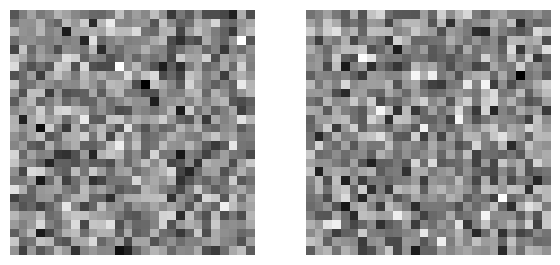

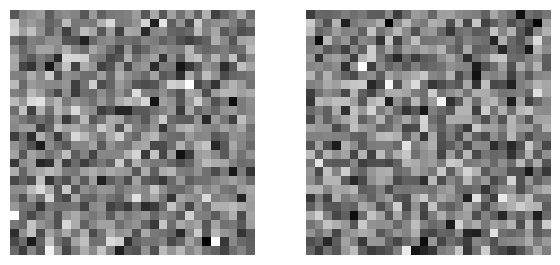

Epoch:0, Step:0, D-Loss:7.712, D-Acc:50.000, G-Loss:15.425
Epoch:0, Step:50, D-Loss:0.191, D-Acc:98.000, G-Loss:1.843
Epoch:0, Step:100, D-Loss:0.380, D-Acc:92.000, G-Loss:1.523
Epoch:0, Step:150, D-Loss:0.528, D-Acc:73.000, G-Loss:0.841
Epoch:0, Step:200, D-Loss:0.382, D-Acc:88.000, G-Loss:2.247
Epoch:0, Step:250, D-Loss:0.309, D-Acc:91.000, G-Loss:4.639
Epoch:0, Step:300, D-Loss:7.628, D-Acc:50.000, G-Loss:0.000
Epoch:0, Step:350, D-Loss:0.386, D-Acc:79.000, G-Loss:3.161
Epoch:0, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:0, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:1, Step:300, D-Loss:7.625, D-Acc:50.000

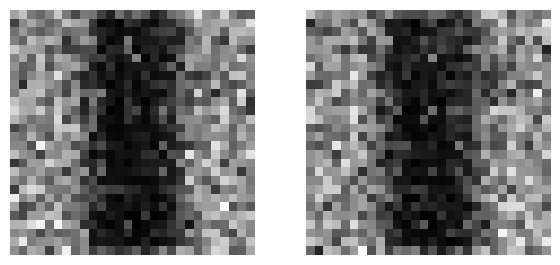

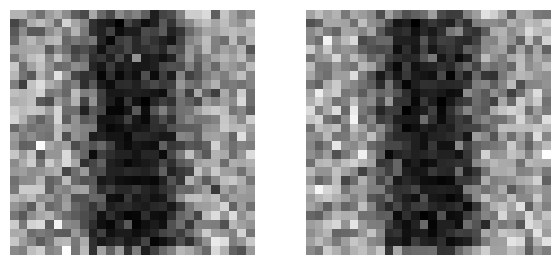

Epoch:10, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:300, D-Loss:7.630, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:10, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:11, Step:300, D-Loss:7.6

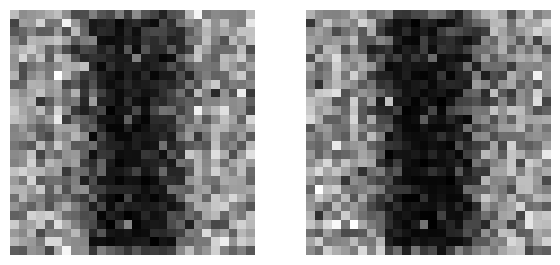

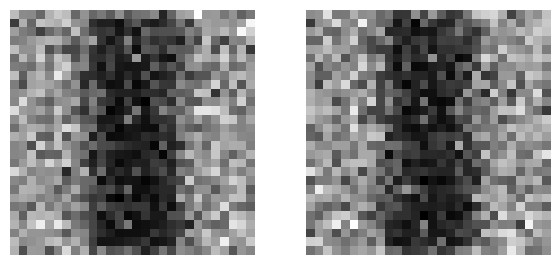

Epoch:20, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:20, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:21, Step:300, D-Loss:7.6

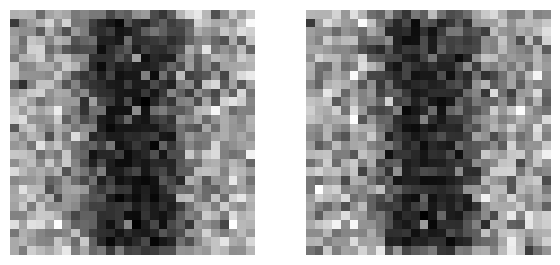

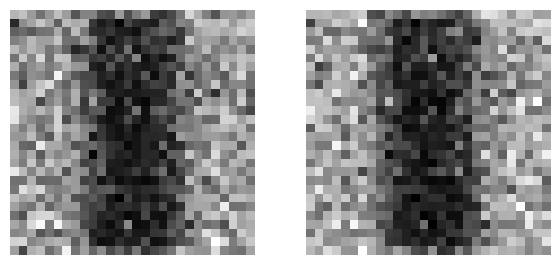

Epoch:30, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:30, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:31, Step:300, D-Loss:7.6

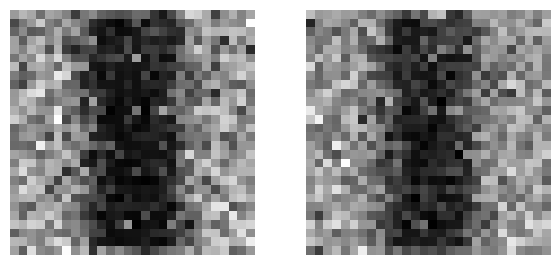

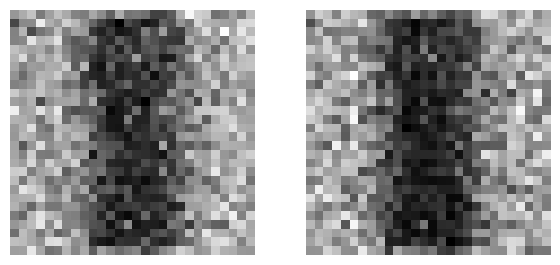

Epoch:40, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:40, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:41, Step:300, D-Loss:7.6

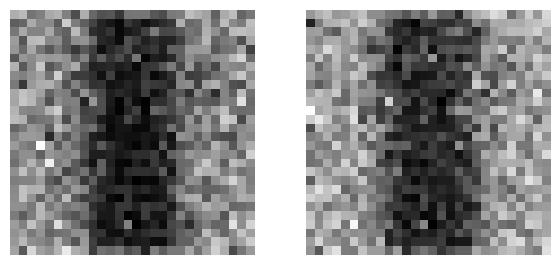

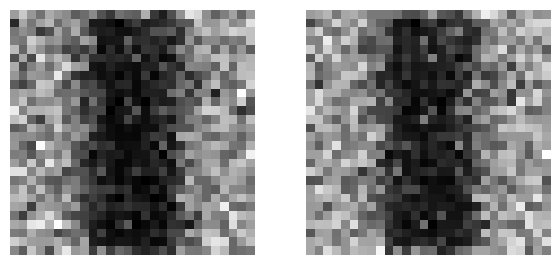

Epoch:50, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:50, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:51, Step:300, D-Loss:7.6

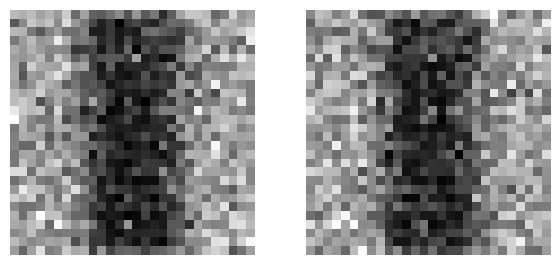

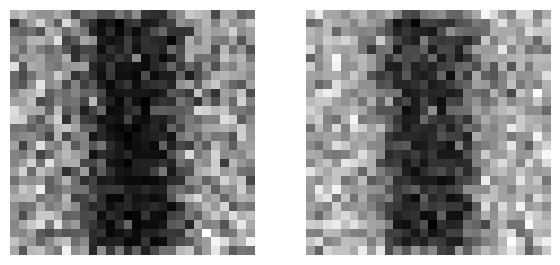

Epoch:60, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:60, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:61, Step:300, D-Loss:7.6

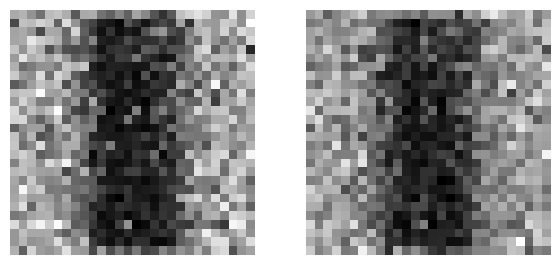

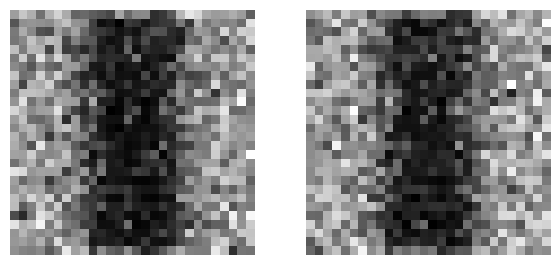

Epoch:70, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:70, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:71, Step:300, D-Loss:7.6

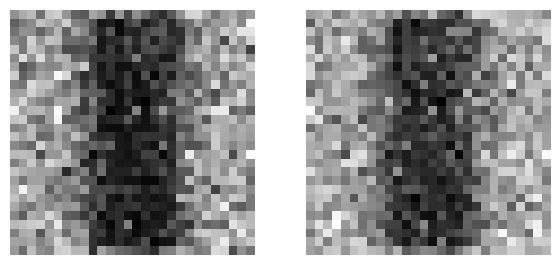

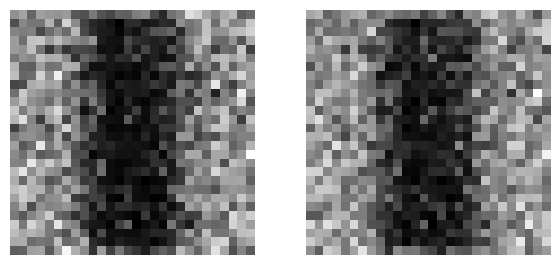

Epoch:80, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:80, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:81, Step:300, D-Loss:7.6

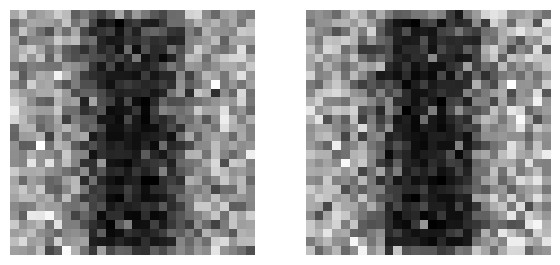

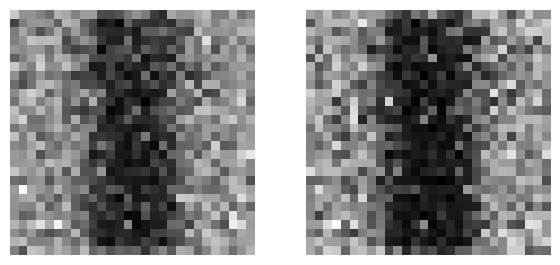

Epoch:90, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:300, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:350, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:400, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:90, Step:450, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:0, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:50, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:100, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:150, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:200, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:250, D-Loss:7.625, D-Acc:50.000, G-Loss:0.000
Epoch:91, Step:300, D-Loss:7.6

In [ ]:
epochs = 100
batch_size = 100
steps = 500
noise_size = 102

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

### Show Results

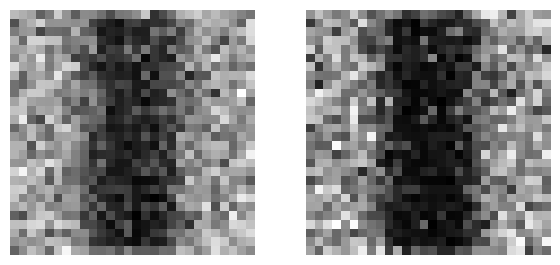

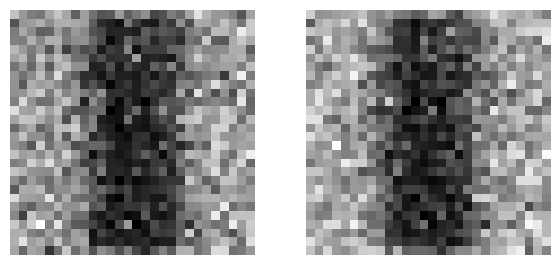

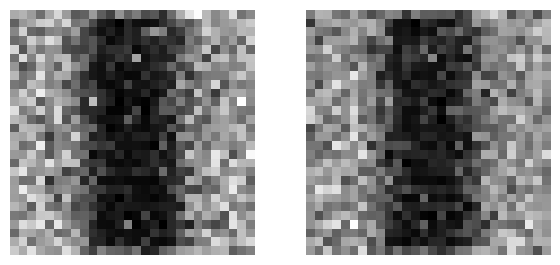

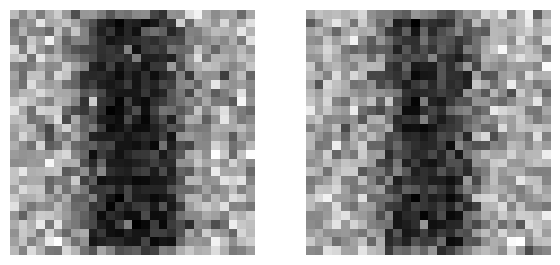

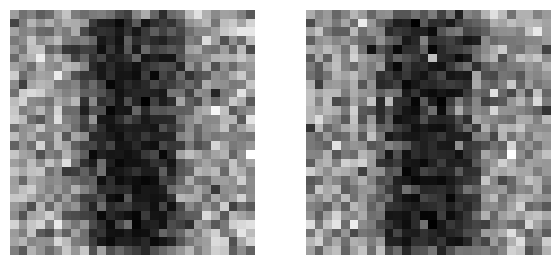

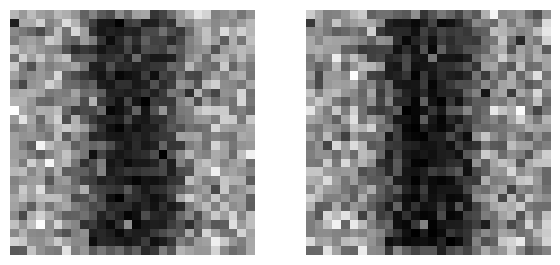

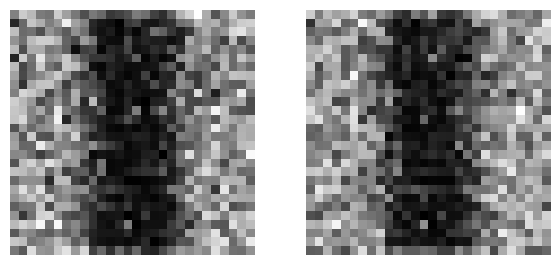

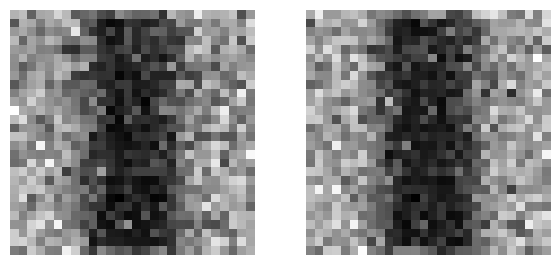

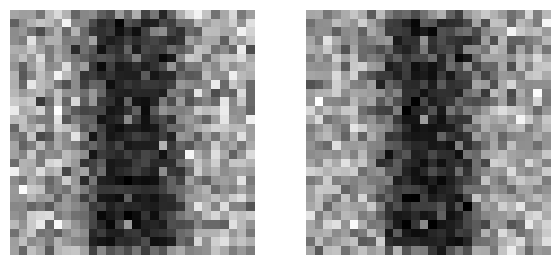

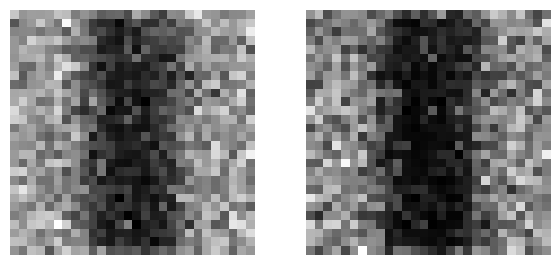

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)

#### Actual Images

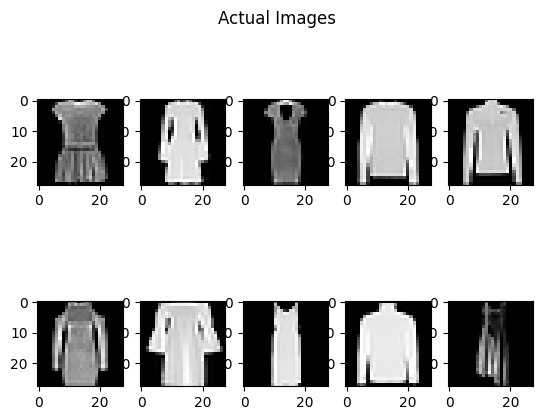

In [ ]:
fig,axe=plt.subplots(2,5)
fig.suptitle("Actual Images")
idx = 0
for i in range(2):
    for j in range(5):
        axe[i,j].imshow(train_images[idx].reshape(28,28),cmap='gray')
        idx+=10

#### Noise Images

In [ ]:
noise_shape = 102
noise=np.random.normal(loc=0, scale=1, size=(100,noise_shape))

gen_image = generator_network.predict(noise)

4/4 [==============================] - 0s 7ms/step


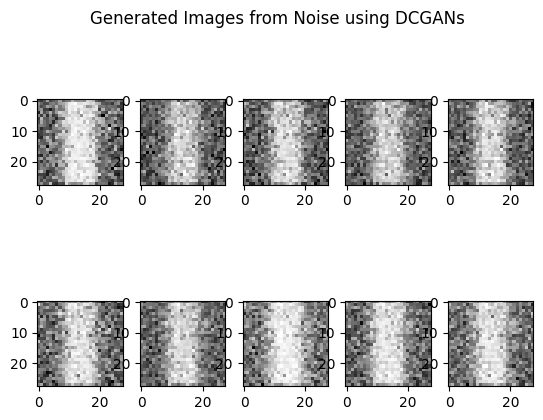

In [ ]:
fig,axe=plt.subplots(2,5)
fig.suptitle('Generated Images from Noise using DCGANs')
idx=0
for i in range(2):
     for j in range(5):
         axe[i,j].imshow(gen_image[idx].reshape(28,28),cmap='gray')
         idx+=3

### Plot GAN loss

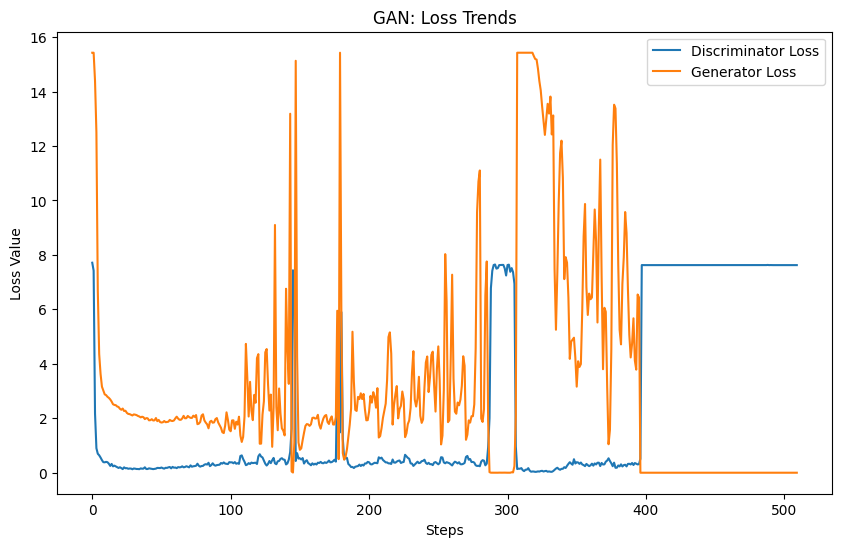

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:510])
plt.plot(losses_g[:510])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

### Evaluasi menggunakan Fréchet Inception Distance (FID)

In [ ]:
import numpy as np
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize

# Scale images to a new size
def scale_images(images, new_shape):
    images_list = [resize(image, new_shape, 0) for image in images]
    return np.asarray(images_list)

# Calculate Frechet Inception Distance
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Prepare the InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Evaluate FID score
def evaluate_fid(generator_network, inception_model, num_images, noise_dim, train_images, num_labels):
    noise = np.random.randn(num_images, noise_dim)
    random_labels = np.random.randint(0, num_labels, num_images)
    one_hot_labels = tf.keras.utils.to_categorical(random_labels, num_classes=num_labels)
    noise_and_labels = np.hstack((noise, one_hot_labels))
    fake_images = generator_network.predict(noise_and_labels)

    real_images = train_images[:num_images]

    fake_images_resized = scale_images(fake_images, (299, 299, 3))
    real_images_resized = scale_images(real_images, (299, 299, 3))

    fake_images_resized = preprocess_input(fake_images_resized)
    real_images_resized = preprocess_input(real_images_resized)

    fid = calculate_fid(inception_model, real_images_resized, fake_images_resized)
    return fid

# Evaluate FID after training
num_images = 1000
noise_dim = 100
num_labels = 2  # Since we're only using labels 2 and 3

fid_score = evaluate_fid(generator_network, inception_model, num_images, noise_dim, train_images, num_labels)
print(f'FID score: {fid_score}')


32/32 [==============================] - 71s 2s/step
FID score: 13.538443639614014


In [ ]:
import numpy as np

def generate_images(generator, num_images, noise_dim, num_labels):
    noise = np.random.randn(num_images, noise_dim)
    random_labels = np.random.randint(0, num_labels, num_images)
    one_hot_labels = tf.keras.utils.to_categorical(random_labels, num_classes=num_labels)
    noise_and_labels = np.hstack((noise, one_hot_labels))
    generated_images = generator.predict(noise_and_labels)
    return generated_images

num_images = 1000
noise_dim = 100
num_labels = 2  # Since we're only using labels 2 and 3
generated_images = generate_images(generator_network, num_images, noise_dim, num_labels)

32/32 [==============================] - 0s 7ms/step


In [ ]:
import numpy as np
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.transform import swirl, resize
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def add_noise(images, amount=0.1):
    return np.array([random_noise(img, var=amount) for img in images])

def add_blur(images, sigma=1):
    return np.array([gaussian(img, sigma=sigma) for img in images])

def add_swirl(images, strength=1):
    return np.array([swirl(img, strength=strength) for img in images])

def add_pixelate(images, factor=0.5):
    pixelated_images = []
    for img in images:
        small = resize(img, (int(img.shape[0] * factor), int(img.shape[1] * factor)), anti_aliasing=True)
        pixelated = resize(small, img.shape, anti_aliasing=True)
        pixelated_images.append(pixelated)
    return np.array(pixelated_images)

# Example disturbances
disturbances = [
    ('No disturbance', lambda x: x),
    ('Noise', lambda x: add_noise(x, amount=0.05)),
    ('Blur', lambda x: add_blur(x, sigma=1)),
    ('Swirl', lambda x: add_swirl(x, strength=2)),
    ('Pixelate', lambda x: add_pixelate(x, factor=0.2))
]

def scale_images(images, new_shape):
    return np.array([resize(img, new_shape, anti_aliasing=True) for img in images])

def calculate_fid(model, images1, images2):
    # Get the activations for both sets of images
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # Calculate the mean and covariance of the activations
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # Calculate the sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # Calculate the product of covariances
    covmean = np.sqrt(np.dot(sigma1, sigma2))
    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def evaluate_disturbances(generator_images, disturbances, inception_model, num_images):
    fid_scores = []
    for name, disturbance_fn in disturbances:
        disturbed_images = disturbance_fn(generator_images[:num_images])
        disturbed_images_resized = scale_images(disturbed_images, (299, 299, 3))
        disturbed_images_resized = preprocess_input(disturbed_images_resized)
        
        generator_images_resized = scale_images(generator_images[:num_images], (299, 299, 3))
        generator_images_resized = preprocess_input(generator_images_resized)
        
        fid = calculate_fid(inception_model, generator_images_resized, disturbed_images_resized)
        fid_scores.append((name, fid))
    return fid_scores

# Assuming `generated_images` and `inception_model` are defined, and `num_images` is set
num_images = 100  # or any number of images you want to evaluate
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
generated_images = np.random.rand(num_images, 28, 28, 1)  # Placeholder for your generated images

fid_scores = evaluate_disturbances(generated_images, disturbances, inception_model, num_images)
print(fid_scores)

4/4 [==============================] - 8s 2s/step


C:\Users\Rachel\AppData\Local\Temp\ipykernel_7312\3227181554.py:46: RuntimeWarning: invalid value encountered in sqrt
  covmean = np.sqrt(np.dot(sigma1, sigma2))


4/4 [==============================] - 7s 2s/step
[('No disturbance', -2.1544855976046797), ('Noise', nan), ('Blur', nan), ('Swirl', nan), ('Pixelate', nan)]


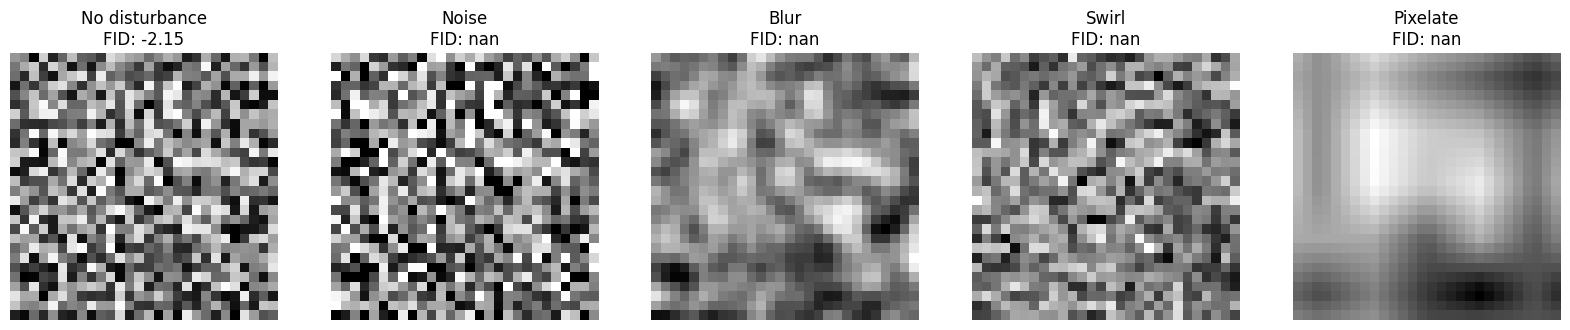

In [ ]:
import matplotlib.pyplot as plt
# Displaying images for visualization
n = len(disturbances)
plt.figure(figsize=(20, 4))
for i, (name, disturbance_fn) in enumerate(disturbances):
    disturbed_images = disturbance_fn(generated_images[:1])
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(disturbed_images[0].squeeze(), cmap='gray')
    plt.title(f"{name}\nFID: {fid_scores[i][1]:.2f}")
    plt.axis('off')
plt.show()


## c. Arsitektur yang dibangun untuk melakukan Image Generation

![![image.png](https://)](attachment:image.png)